In [1]:
# imports inline with PEP8 
import datetime

import pandas as pd 
import numpy as np

# custom built imports 
from dbconn import db # to dependency of geopandas in dimension 


In [2]:
#### FUNCTIONS created 
# to move and refactor to classes 


###### Dataframes from database 
def get_df_of_collection(collection, db = db, query = {}, subset = {'_id' : 0}):
    """For a collection get a dataframe"""
    df = pd.DataFrame(list((db[collection].find( query, subset)))) 
    return df 
    

def get_sensorvalues_df_by_tag( tag_name, db = db):
    """From sensor values get a df of tag_name sorted by measurement_timestamp  """
    try:
        df = get_df_of_collection(collection = 'sensor_values', query = {"tag_name" : {"$eq": tag_name }}, )
        df = df.sort_values(by='measurement_timestamp')
        df.reset_index(inplace =True, drop = True)
        
        return df 
    except Exception as e: 
        print("Error in finding df, does the tag exist in sensor_values collection? Erroe: ", e)
        return e 

     

def get_alarmvalues_df_by_tag( tag_name, db = db):
    # NOT PURE CHNAGE AND SPLIT - NOTE this is used for washing alarm so change call there before change here 
    # this should be same as get_turbidity_values_df_by_tag() which would call this and make changes 
    # similarliy the changes in herearound dict washing need to occur in a new function 
    # get_washingactive_values_df_by_tag()
    """From sensor values get a df of tag_name sorted by measurement_timestamp  """
    try:
        df = get_df_of_collection(collection = 'alarm_values', query = {"tag_name" : {"$eq": tag_name }}, )
        df = df.sort_values(by='measurement_timestamp')
        df.reset_index(inplace =True, drop = True)
        # below should be if washing df do this - add elsif 
        print("len before droping error washing: ", len(df))
        dict_washing = {'Inactive': 0, 'Active': 1} # other keys are IO error 
        df = df.loc[df['measurement_value'].isin(list(dict_washing.keys()))]
        print("len after droping error washing: ", len(df))
        #map values to 01 
        df['washing'] = df['measurement_value'].map(dict_washing)
        return df 
    except Exception as e: 
        print("Error in finding df, does the tag exist in alarm values collection? Error: ", e)
        return e 
    
def get_turbidity_values_df_by_tag( tag_name, db = db):
    """From sensor values get a df of tag_name sorted by measurement_timestamp  """
    try:
        df = get_df_of_collection(collection = 'alarm_values', query = {"tag_name" : {"$eq": tag_name }}, )
        df = df.sort_values(by='measurement_timestamp')
        df.reset_index(inplace =True, drop = True)
        # below should be if washing df do this - add elsif 
        return df 
    except Exception as e: 
        print("Error in finding df, does the tag exist in alarm values collection? Error: ", e)
        return e 

def get_RGFn_dataframes_by_site(site):
    """For a given site gets a dict of RGF dataframes"""
    df = get_df_of_collection(collection = 'site_tag_config', 
                                  query = {"site_name" : {"$eq": site }}, 
                                 )
    pattern = [f'RGF{n}' for n in range(1, 7)]
    
    def get_df_add_RGFn_column(df, k): 
        df = df.loc[df['tag_name'].str.contains(k)].copy()
        df['RGFid'] = k
        return df     
    
    df_dict = { k: get_df_add_RGFn_column(df, k) for k in pattern }
    
    return df_dict
    
def get_df_stats(df, columns = None):
    """For a column get some stats"""
    if columns: 
        print(df[columns].describe(()))
        print("median", df[columns].median())
        print("mode", df[columns].mode())
        # how to do modal count across columns
    else: 
        print(df.describe(()))
        print("median", df.median())
        print("mode", df.mode())
        
        
#### dfs manipulation of collections insside database 

def get_binary_event_start_times(df, binary_event_col, relevant_cols):
    """Takes a dataframe with a number of timestamps all assigned an event in binary format
    If your event of interest is not in a binary column covvert it 
    If you have more than 2 events ("on/Off or yes/no etc")  you need to drop to binary 
    """
    # take the binary_event_col and get the previous value
    df_event = df.copy()
    df_event[f'previous{binary_event_col}']= df_event[binary_event_col].shift(1)
    # compare the 2 columns to make an event change col
    df_event[f'change_of_{binary_event_col}'] = np.where(df_event[binary_event_col] == 
                                                         df_event[f'previous{binary_event_col}'], 
                                                         False, 
                                                         True, 
                                                        )
    
    dfevent = df.loc[df['washing_change'] == True][cols_].copy()
    df_event['time_of_prior_event'] = df_event['measurement_timestamp'].diff()
    df_event['time_event'] = df_event['time_of_prior_event'].shift(-1)
    df_event['time_event_hrs'] = df_event['time_event'] / np.timedelta64(1, 'h')
    return df_event
    
    
    
#### Plots 
    
def get_timeseries(df,  title = "title", date_col = 'measurement_timestamp', feature = 'measurement_value'):
    """Get a time series witrh slider for fetare of dataframe df with date column date_col"""
    fig = px.line(df,
              x=date_col, 
              y= feature, 
              title=f'title: {feature}')

    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )

    return fig


def get_binary_heatmap(x, y, z):
    """Gets a heat binary map for a dataframe """
    
    fig = go.Figure(data=go.Heatmap(
        z=z,
        x=x,
        y=y,
        colorscale=[
        [0.0, "rgb(0, 100, 0)"],
        [1.0, "rgb(255, 0, 0)"],], 
        )
        )
    

    fig.update_layout(
        title='Washes',
        showlegend=False, 
        #xaxis_nticks=36
    )
    
    return fig 


def get_histogram_binary_event_duration(df, event_col_time, event_col_text = None, **kargs ):
    """Get a histogram for a bianry_event_time created from func. get_binary_event_start_times()"""
    
    fig = px.histogram(df, 
                   x = event_col_time, 
                   nbins = 385, 
                   color = event_col_text , 
                   marginal = "box",  
                   hover_data = df.columns, 
                    )
    
    
    return fig



In [4]:
# site tag config 
# all of the scada tags in the database 
# are ll of these real scada tags or are some virtual? 

df_primary_keys = pd.DataFrame(list(db['site_tag_config'].find()))
df_primary_keys.tail()

_id  datafeed_timestamp  site_name   scada_tag  \
4002  5fd35920bbfcc0c6884cf1d4 2021-01-04 12:48:34  ELVINGTON    EHT3001C   
4003  5fd35920bbfcc0c6884cf1d5 2021-01-04 12:48:34  ELVINGTON    EHT3002C   
4004  5fd35920bbfcc0c6884cf1f0 2021-01-04 12:48:34  ELVINGTON  MF29161_RN   
4005  5fd35920bbfcc0c6884cf23c 2021-01-04 12:48:34  ELVINGTON  MF29162_RN   
4006  5fd35920bbfcc0c6884cf294 2021-01-04 12:48:34  ELVINGTON  MF29163_RN   

                 tag_name                             tag_description  \
4002    ELVGTNS1:EHT3001C       Elvington To Harton Sunction Pressure   
4003    ELVGTNS1:EHT3002C       Elvington To Harton Delivery Pressure   
4004  ELVGTNS1:MF29161_RN  Multiflo 1 Poly Dosing Pump Running Status   
4005  ELVGTNS1:MF29162_RN  Multiflo 2 Poly Dosing Pump Running Status   
4006  ELVGTNS1:MF29163_RN  Multiflo 3 Poly Dosing Pump Running Status   

     measurement_unit               tag_short_description common_reference  \
4002              Bar  Elvington To Harton Sunction Press              TBD   
4003              Bar  Elvington To Harton Delivery Press              TBD   
4004             Text         MFLO 1 POL DOS PUMP Running      SAI00177305   
4005             Text         MFLO 2 POL DOS PUMP Running      SAI00177306   
4006             Text         MFLO 3 POL DOS PUMP Running      SAI00177307   

     tag_category  ... lo_calculated lolo_calculated hihi_used hi_used  \
4002     Pressure  ...           NaN             NaN       NaN     NaN   
4003     Pressure  ...           NaN             NaN       NaN     NaN   
4004         Pump  ...           NaN             NaN       NaN     NaN   
4005         Pump  ...           NaN             NaN       NaN     NaN   
4006         Pump  ...           NaN             NaN       NaN     NaN   

     lo_used lolo_used  rate_of_change_used  is_alarm  sensor_low sensor_high  
4002     NaN       NaN                  NaN     False         0.0        10.0  
4003     NaN       NaN                  NaN     False         0.0        16.0  
4004     NaN       NaN                  NaN      True         NaN         NaN  
4005     NaN       NaN                  NaN      True         NaN         NaN  
4006     NaN       NaN                  NaN      True         NaN         NaN  

[5 rows x 44 columns]

In [9]:
# Look for all values with turbidity units NTU
df_latest = pd.DataFrame(list(db['sensor_values_latest'].find( {} ,
                                                                {"_id" : 0}                                                             )))
df_latest.head()

df_latest.loc[(df_latest['measurement_unit'] == 'NTU' ) & 
             (df_latest['site_name'] == 'HUBY' ) 
             ]

tag_name measurement_timestamp  \
225        HUBYWTS1:RAW_WATER_TURBIDITY_SI   2021-03-22 19:45:40   
242                       HUBYWTS1:RGF4_TB   2020-09-25 09:11:43   
256       HUBYWTS1:RAW_WATER_TURBIDITY_RAW   2021-03-22 19:54:40   
260                       HUBYWTS1:RGF6_TB   2021-03-22 19:49:10   
263                       HUBYWTS1:RGF3_TB   2020-09-25 09:07:13   
275                       HUBYWTS1:RGF5_TB   2021-03-22 19:55:10   
294                    HUBYWTS1:RGF3_TB_SI   2021-03-22 19:59:10   
297                       HUBYWTS1:RGF2_TB   2020-09-25 09:03:43   
301                       HUBYWTS1:RGF1_TB   2020-09-25 09:03:13   
310                    HUBYWTS1:RGF4_TB_SI   2021-03-22 19:57:10   
314             HUBYWTS1:RGF_COMMON_TB_TRD   2021-03-22 19:57:40   
360                    HUBYWTS1:RGF2_TB_SI   2021-03-22 19:53:10   
379              HUBYWTS1:RGF_COMMON_TB_SI   2021-03-22 19:45:40   
391              HUBYWTS1:GAC_DW_QIT890SCD   2021-03-22 19:48:40   
416                    HUBYWTS1:RGF1_TB_SI   2021-03-22 19:55:10   
442                    HUBYWTS1:RGF6_TB_SI   2021-03-22 19:43:10   
471  HUBYWTS1:CLARIFIED_WATER_TURBIDITY_SI   2021-03-22 19:53:40   
521                    HUBYWTS1:RGF5_TB_SI   2021-03-22 19:44:40   
537      HUBYWTS1:FINAL_WATER_TURBIDITY_SI   2021-03-22 19:50:40   

     measurement_value site_name               functional_area  \
225            10.4200      HUBY            1-Raw Water Intake   
242           157.0000      HUBY                  3-Filtration   
256           495.0000      HUBY            1-Raw Water Intake   
260           148.0000      HUBY                  3-Filtration   
263           209.0000      HUBY                  3-Filtration   
275           125.0000      HUBY                  3-Filtration   
294             0.0578      HUBY                  3-Filtration   
297           164.0000      HUBY                  3-Filtration   
301           199.0000      HUBY                  3-Filtration   
310             0.0328      HUBY                  3-Filtration   
314             0.0406      HUBY                  3-Filtration   
360             0.1520      HUBY                  3-Filtration   
379             0.0554      HUBY                  3-Filtration   
391             0.0200      HUBY           4-Pesticide Removal   
416             0.0386      HUBY                  3-Filtration   
442             0.0302      HUBY                  3-Filtration   
471             2.2530      HUBY               2-Clarification   
521             0.0258      HUBY                  3-Filtration   
537             0.0338      HUBY  6-Treated Water Distribution   

          site_specific_schematic                  process_area  \
225            Raw Water Sampling            Raw Water Sampling   
242      Rapid Gravity Filtration         Rapid Gravity Filters   
256            Raw Water Sampling            Raw Water Sampling   
260      Rapid Gravity Filtration         Rapid Gravity Filters   
263      Rapid Gravity Filtration         Rapid Gravity Filters   
275      Rapid Gravity Filtration         Rapid Gravity Filters   
294      Rapid Gravity Filtration         Rapid Gravity Filters   
297      Rapid Gravity Filtration         Rapid Gravity Filters   
301      Rapid Gravity Filtration         Rapid Gravity Filters   
310      Rapid Gravity Filtration         Rapid Gravity Filters   
314      Rapid Gravity Filtration         Rapid Gravity Filters   
360      Rapid Gravity Filtration         Rapid Gravity Filters   
379      Rapid Gravity Filtration         Rapid Gravity Filters   
391   Activated Carbon Filtration        GAC Feed Tanks & Pumps   
416      Rapid Gravity Filtration         Rapid Gravity Filters   
442  Combined RGF Outlet Sampling  Combined RGF Outlet Sampling   
471      Clarified Water Sampling      Clarified Water Sampling   
521      Rapid Gravity Filtration         Rapid Gravity Filters   
537        Treated Water Sampling        Treated Water Sampling   

    measure

# Get dfs for global values 

In [3]:
df_HUBY_preRGF_raw_water_TB = get_sensorvalues_df_by_tag( tag_name = 'HUBYWTS1:RAW_WATER_TURBIDITY_RAW' , # no SI ? 
                                                               db = db)

df_HUBY_preRGF_raw_water_TB.head()

tag_name measurement_timestamp  measurement_value  \
0  HUBYWTS1:RAW_WATER_TURBIDITY_RAW   2020-05-15 12:45:00           366.0000   
1  HUBYWTS1:RAW_WATER_TURBIDITY_RAW   2020-05-15 13:00:00           370.7778   
2  HUBYWTS1:RAW_WATER_TURBIDITY_RAW   2020-05-15 13:15:00           393.0000   
3  HUBYWTS1:RAW_WATER_TURBIDITY_RAW   2020-05-15 13:30:00           377.0000   
4  HUBYWTS1:RAW_WATER_TURBIDITY_RAW   2020-05-15 13:45:00           383.3333   

  site_name     functional_area site_specific_schematic        process_area  \
0      HUBY  1-Raw Water Intake      Raw Water Sampling  Raw Water Sampling   
1      HUBY  1-Raw Water Intake      Raw Water Sampling  Raw Water Sampling   
2      HUBY  1-Raw Water Intake      Raw Water Sampling  Raw Water Sampling   
3      HUBY  1-Raw Water Intake      Raw Water Sampling  Raw Water Sampling   
4      HUBY  1-Raw Water Intake      Raw Water Sampling  Raw Water Sampling   

  measurement_unit  is_alarm low   high  sensor_low  sensor_high  is_suspect  
0              NTU     False   0  20000         0.0      20000.0       False  
1              NTU     False   0  20000         0.0      20000.0       False  
2              NTU     False   0  20000         0.0      20000.0       False  
3              NTU     False   0  20000         0.0      20000.0       False  
4              NTU     False   0  20000         0.0      20000.0       False

In [4]:
# is this combined across all or finanl? assume final but need to assert 
df_HUBY_preRGF_clarified = get_sensorvalues_df_by_tag( tag_name = 'HUBYWTS1:CLARIFIED_WATER_TURBIDITY_SI' , 
                                                               db = db)

df_HUBY_preRGF_clarified.head()

tag_name measurement_timestamp  \
0  HUBYWTS1:CLARIFIED_WATER_TURBIDITY_SI   2019-07-01 00:00:00   
1  HUBYWTS1:CLARIFIED_WATER_TURBIDITY_SI   2019-07-01 00:15:00   
2  HUBYWTS1:CLARIFIED_WATER_TURBIDITY_SI   2019-07-01 00:30:00   
3  HUBYWTS1:CLARIFIED_WATER_TURBIDITY_SI   2019-07-01 00:45:00   
4  HUBYWTS1:CLARIFIED_WATER_TURBIDITY_SI   2019-07-01 01:00:00   

   measurement_value site_name  functional_area   site_specific_schematic  \
0           1.266158      HUBY  2-Clarification  Clarified Water Sampling   
1           1.174421      HUBY  2-Clarification  Clarified Water Sampling   
2           1.288737      HUBY  2-Clarification  Clarified Water Sampling   
3           1.167474      HUBY  2-Clarification  Clarified Water Sampling   
4           1.281111      HUBY  2-Clarification  Clarified Water Sampling   

               process_area measurement_unit  is_alarm    low high sensor_low  \
0  Clarified Water Sampling              NTU     False  (A*B)    0       None   
1  Clarified Water Sampling              NTU     False  (A*B)    0       None   
2  Clarified Water Sampling              NTU     False  (A*B)    0       None   
3  Clarified Water Sampling              NTU     False  (A*B)    0       None   
4  Clarified Water Sampling              NTU     False  (A*B)    0       None   

   sensor_high  is_suspect  
0          0.0       False  
1          0.0       False  
2          0.0       False  
3          0.0       False  
4          0.0       False

In [5]:
# is this combined across all or finanl? assume final but need to assert 
df_HUBY_RGF_common_water_TB = get_sensorvalues_df_by_tag( tag_name = 'HUBYWTS1:RGF_COMMON_TB_SI' , 
                                                               db = db)

df_HUBY_RGF_common_water_TB.head()

tag_name measurement_timestamp  measurement_value  \
0  HUBYWTS1:RGF_COMMON_TB_SI   2020-09-04 14:26:19             0.0818   
1  HUBYWTS1:RGF_COMMON_TB_SI   2020-09-04 14:39:19             0.0728   
2  HUBYWTS1:RGF_COMMON_TB_SI   2020-09-04 14:41:19             0.0818   
3  HUBYWTS1:RGF_COMMON_TB_SI   2020-09-04 14:43:19             0.0824   
4  HUBYWTS1:RGF_COMMON_TB_SI   2020-09-04 14:47:49             0.0858   

  site_name functional_area   site_specific_schematic           process_area  \
0      HUBY    3-Filtration  Rapid Gravity Filtration  Rapid Gravity Filters   
1      HUBY    3-Filtration  Rapid Gravity Filtration  Rapid Gravity Filters   
2      HUBY    3-Filtration  Rapid Gravity Filtration  Rapid Gravity Filters   
3      HUBY    3-Filtration  Rapid Gravity Filtration  Rapid Gravity Filters   
4      HUBY    3-Filtration  Rapid Gravity Filtration  Rapid Gravity Filters   

  measurement_unit  is_alarm    low high sensor_low  sensor_high  is_suspect  
0              NTU     False  (A*B)    0       None          0.0       False  
1              NTU     False  (A*B)    0       None          0.0       False  
2              NTU     False  (A*B)    0       None          0.0       False  
3              NTU     False  (A*B)    0       None          0.0       False  
4              NTU     False  (A*B)    0       None          0.0       False

# combine global dataframes  

In [33]:
list_global_dfs = [df_HUBY_preRGF_raw_water_TB, df_HUBY_preRGF_clarified, df_HUBY_RGF_common_water_TB]

cols_ = ['measurement_timestamp', 'measurement_value']
df_combined_buildup = df_HUBY_preRGF_raw_water_TB[cols_].copy() # start global df with raw water df 
df_combined_buildup.rename({'measurement_value' : 'measurement_value_raw'}, axis =1, inplace = True)
print(len(df_combined_buildup))

df_combined_buildup = df_combined_buildup.merge(df_HUBY_preRGF_clarified[cols_].copy(), # to global df add clarified df
                          left_on='measurement_timestamp', 
                          right_on='measurement_timestamp', 
                           how = 'left', 
                                               )
df_combined_buildup.rename({'measurement_value' : 'measurement_value_clarified'}, axis =1, inplace = True)
print(len(df_combined_buildup))

df_combined_buildup = df_combined_buildup.merge(df_HUBY_RGF_common_water_TB[cols_].copy(), # to global df add combined df
                          left_on='measurement_timestamp', 
                          right_on='measurement_timestamp', 
                            how = 'left', )
df_combined_buildup.rename({'measurement_value' : 'measurement_value_clarified'}, axis =1, inplace = True)
print(len(df_combined_buildup))

df_combined_buildup.head()

608454
608454
608454


measurement_timestamp  measurement_value_raw  measurement_value_clarified  \
0   2020-05-15 12:45:00               366.0000                     1.160533   
1   2020-05-15 13:00:00               370.7778                     1.162146   
2   2020-05-15 13:15:00               393.0000                     1.163760   
3   2020-05-15 13:30:00               377.0000                     1.165373   
4   2020-05-15 13:45:00               383.3333                     1.166986   

   measurement_value_clarified  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN

In [23]:
len(df_combined_buildup)

16171

# Get dataframes dictionaries for each RGF 

In [8]:
# Levels 
dict_RGF_levels = { k : get_sensorvalues_df_by_tag( tag_name = k , db = db) 
                 for k in [f"HUBYWTS1:RGF{i}_LEVEL_SI" 
                 for i in range(1, 7)] 
                }

In [9]:
# Outlet Flow
dict_RGF_outlet_flow = { k : get_sensorvalues_df_by_tag( tag_name = k , db = db) 
                 for k in [f"HUBYWTS1:RGF{i}_FLOW_SI" 
                 for i in range(1, 7)] 
                }


In [10]:
# Turbidity (outlet?)
dict_RGF_turbidity = { k : get_sensorvalues_df_by_tag( tag_name = k , db = db) 
                 for k in [f"HUBYWTS1:RGF{i}_TB_SI" 
                 for i in range(1, 7)] 
                }

In [11]:
#differenital pressure 
dict_RGF_diffrential_pressure = { k : get_sensorvalues_df_by_tag( tag_name = k , db = db) 
                 for k in [f"HUBYWTS1:RGF{i}_DP" 
                 for i in range(1, 7)] 
                }

In [12]:
# washing 
dict_RGF_washing = { k : get_sensorvalues_df_by_tag( tag_name = k , db = db) 
                 for k in [f"'HUBYWTS1:RGF{i}_WASHING" 
                 for i in range(1, 7)] 
                }


Error in finding df, does the tag exist in sensor_values collection? Erroe:  'measurement_timestamp'
Error in finding df, does the tag exist in sensor_values collection? Erroe:  'measurement_timestamp'
Error in finding df, does the tag exist in sensor_values collection? Erroe:  'measurement_timestamp'
Error in finding df, does the tag exist in sensor_values collection? Erroe:  'measurement_timestamp'
Error in finding df, does the tag exist in sensor_values collection? Erroe:  'measurement_timestamp'
Error in finding df, does the tag exist in sensor_values collection? Erroe:  'measurement_timestamp'


In [ ]:
dict_RGF_washing

# combine all indvidual RGFn df to global df 

In [14]:
# pusedo code 
# for item in dict 
# merge item and cols_ to df 
# remane column from key 
# move on

for k, v in dict_RGF_levels.items():
    df_combined_buildup = df_combined_buildup.merge(v[cols_].copy(), # to global df add combined df
                          left_on='measurement_timestamp', 
                          right_on='measurement_timestamp' )
    df_combined_buildup.rename({'measurement_value' : f'measurement_value_{k}'}, axis =1, inplace = True)
df_combined_buildup.head()  



measurement_timestamp  measurement_value_raw  measurement_value_clarified  \
0   2020-09-12 07:59:49                 1663.0                        3.153   
1   2020-09-13 17:16:31                   31.0                       29.997   
2   2020-09-13 17:26:31                   24.0                       29.997   
3   2020-09-14 16:29:31                  809.0                        5.955   
4   2020-12-13 11:15:00                  937.0                        4.788   

   measurement_value_clarified  measurement_value_HUBYWTS1:RGF1_LEVEL_SI  \
0                       0.0676                                    1.6472   
1                       0.6472                                    1.5510   
2                       0.6472                                    1.5510   
3                       0.1912                                    1.6196   
4                       0.0748                                    1.6246   

   measurement_value_HUBYWTS1:RGF2_LEVEL_SI  \
0                                    1.7600   
1                                    0.0398   
2                                    0.0386   
3                                    1.7426   
4                                    1.6830   

   measurement_value_HUBYWTS1:RGF3_LEVEL_SI  \
0                                    1.7298   
1                                    1.6940   
2                                    1.6946   
3                                    0.3148   
4                                    1.7086   

   measurement_value_HUBYWTS1:RGF4_LEVEL_SI  \
0                                    1.7414   
1                                    1.7594   
2                                    1.7594   
3                                    1.7222   
4                                    1.7246   

   measurement_value_HUBYWTS1:RGF5_LEVEL_SI  \
0                                    1.6414   
1                                    1.5708   
2                                    1.5714   
3                                    1.5882   
4                                    1.6150   

   measurement_value_HUBYWTS1:RGF6_LEVEL_SI  
0                                    1.6048  
1                                    1.5452  
2                                    1.5446  
3                                    1.5438  
4                                    1.5836

In [34]:

def add_df_dict_to_global_df(df_dict, df_global = df_combined_buildup):
    """takes a dict of dataframes and adds to a global df"""
    print("df global lenght at start", len(df_global))
    for k, v in df_dict.items():
        df_global = df_combined_buildup.merge(v[cols_].copy(), # to global df add combined df
                              left_on='measurement_timestamp', 
                              right_on='measurement_timestamp', 
                               how = 'left', 
                                             )
        df_global.rename({'measurement_value' : f'measurement_value_{k}'}, axis =1, inplace = True)
        print(f"length dfglobal after addiation of {k} : ", len(df_global))
    print(len(df_global))
    return df_global 
    

In [35]:
df_combined_buildup = add_df_dict_to_global_df(df_dict = dict_RGF_levels , df_global = df_combined_buildup)
df_combined_buildup = add_df_dict_to_global_df(df_dict = dict_RGF_outlet_flow , df_global = df_combined_buildup)
df_combined_buildup = add_df_dict_to_global_df(df_dict = dict_RGF_turbidity , df_global = df_combined_buildup)
df_combined_buildup = add_df_dict_to_global_df(df_dict = dict_RGF_diffrential_pressure , df_global = df_combined_buildup)
df_combined_buildup = add_df_dict_to_global_df(df_dict = dict_RGF_levels , df_global = df_combined_buildup)
df_combined_buildup

df global lenght at start 608454
length dfglobal after addiation of HUBYWTS1:RGF1_LEVEL_SI :  608454
length dfglobal after addiation of HUBYWTS1:RGF2_LEVEL_SI :  608454
length dfglobal after addiation of HUBYWTS1:RGF3_LEVEL_SI :  608454
length dfglobal after addiation of HUBYWTS1:RGF4_LEVEL_SI :  608454
length dfglobal after addiation of HUBYWTS1:RGF5_LEVEL_SI :  608454
length dfglobal after addiation of HUBYWTS1:RGF6_LEVEL_SI :  608454
608454
df global lenght at start 608454
length dfglobal after addiation of HUBYWTS1:RGF1_FLOW_SI :  608454
length dfglobal after addiation of HUBYWTS1:RGF2_FLOW_SI :  608454
length dfglobal after addiation of HUBYWTS1:RGF3_FLOW_SI :  608454
length dfglobal after addiation of HUBYWTS1:RGF4_FLOW_SI :  608454
length dfglobal after addiation of HUBYWTS1:RGF5_FLOW_SI :  608454
length dfglobal after addiation of HUBYWTS1:RGF6_FLOW_SI :  608454
608454
df global lenght at start 608454
length dfglobal after addiation of HUBYWTS1:RGF1_TB_SI :  608454
length dfglo

measurement_timestamp  measurement_value_raw  \
0        2020-05-15 12:45:00               366.0000   
1        2020-05-15 13:00:00               370.7778   
2        2020-05-15 13:15:00               393.0000   
3        2020-05-15 13:30:00               377.0000   
4        2020-05-15 13:45:00               383.3333   
...                      ...                    ...   
608449   2021-03-22 19:56:40               521.0000   
608450   2021-03-22 19:57:10               534.0000   
608451   2021-03-22 19:57:40               524.0000   
608452   2021-03-22 19:59:10               511.0000   
608453   2021-03-22 19:59:40               502.0000   

        measurement_value_clarified  measurement_value_clarified  \
0                          1.160533                          NaN   
1                          1.162146                          NaN   
2                          1.163760                          NaN   
3                          1.165373                          NaN   
4                          1.166986                          NaN   
...                             ...                          ...   
608449                          NaN                          NaN   
608450                          NaN                        0.042   
608451                          NaN                          NaN   
608452                          NaN                          NaN   
608453                          NaN                          NaN   

        measurement_value_HUBYWTS1:RGF6_LEVEL_SI  \
0                                       1.557810   
1                                       1.537031   
2                                       1.559983   
3                                       1.580138   
4                                       1.537210   
...                                          ...   
608449                                       NaN   
608450                                       NaN   
608451                                       NaN   
608452                                       NaN   
608453                                       NaN   

        measurement_value_HUBYWTS1:RGF6_FLOW_SI  \
0                                      13.68721   
1                                      11.13833   
2                                      11.20141   
3                                      14.57525   
4                                      16.13800   
...                                         ...   
608449                                 12.60000   
608450                                      NaN   
608451                                 12.77100   
608452                                 12.83100   
608453                                 12.76200   

        measurement_value_HUBYWTS1:RGF6_TB_SI  \
0                                    0.053154   
1                                    0.053318   
2                                    0.053482   
3                                    0.053646   
4                                    0.053810   
...                                       ...   
608449                                    NaN   
608450                                    NaN   
608451                                    NaN   
608452                                    NaN   
608453                                    NaN   

        measurement_value_HUBYWTS1:RGF6_DP  \
0                                 1995.000   
1                                 1514.667   
2                                 1574.000   
3                                 2304.000   
4                                 2587.000   
...                                    ...   
608449                             167.000   
608450                             173.000   
608451                             180.000   
608452                                 NaN   
608453                                 NaN   

        measurement_value_HUBYWTS1:RGF6_LEVEL_SI  
0                                       1.557810  
1                                       1.53703

In [ ]:
fig = px.line(df_combined_buildup, x='measurement_timestamp', y='measurement_value_raw', title='Huby')

fig.update_xaxes(rangeslider_visible=True)

fig.show()

In [ ]:
def plot_compare_ts(df, x, y1, y2 ):
    "compare 2 ts on 1 plot"
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    x = df[x]

    # Add traces
    fig.add_trace(
        go.Scatter(x=x, y=df[y1], name="yaxis data"),
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x=x, y=df[y2], name="yaxis2 data"),
        secondary_y=True,
    )

    # Add figure title
    fig.update_layout(
        title_text="Double Y Axis Example"
    )

    # Set x-axis title
    fig.update_xaxes(title_text="xaxis title")

    # Set y-axes titles
    fig.update_yaxes(title_text="<b>primary</b> yaxis title", secondary_y=False)
    fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)
    
    return fig 

In [ ]:
def add_trace_to_fig(fig = fig, ):
    fig.add_trace(
        go.Scatter(x=x, y=df[y2], name="yaxis2 data"),
        secondary_y=True,
    )
    
    
    

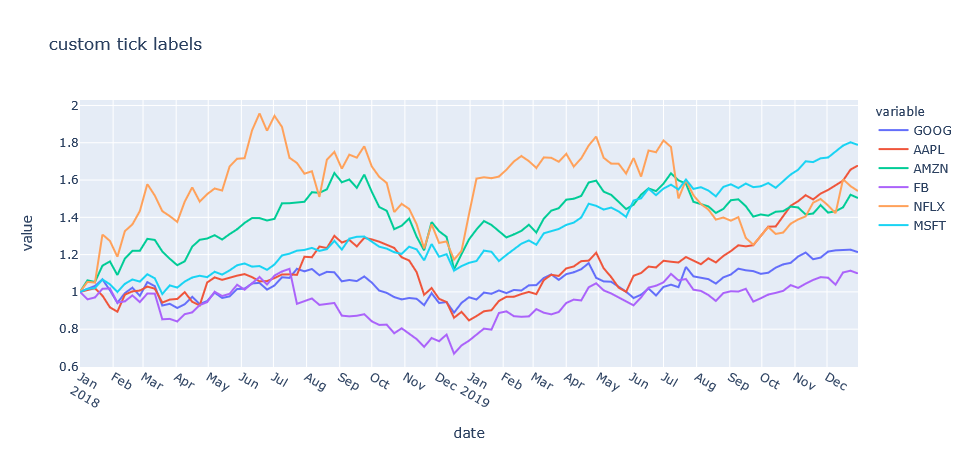

In [36]:
import plotly.express as px
df = px.data.stocks()
fig = px.line(df, x="date", y=df.columns,
              hover_data={"date": "|%B %d, %Y"},
              title='custom tick labels')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

In [7]:
# get all assets across singel site 
# there are 3 sites in the database 

# look at one site 
site = 'HUBY' #  filetreing on'ACOMB' fro RGF1 didnt appear to give all RGF1 
# look for scda tags for RGF1 (there are 6 RGFs) 
n = 1
scada_contains = f'RGF{n}'



df_RGF = df_primary_keys.loc[(df_primary_keys['site_name'] == site )
                   & (df_primary_keys['scada_tag'].str.contains(scada_contains))].copy().reset_index()
df_RGF

index                       _id  datafeed_timestamp site_name  \
0     190  5f289ef08409b3062c42b4ea 2020-09-07 20:52:41      HUBY   
1     191  5f289ef08409b3062c42b4e9 2020-09-07 20:52:41      HUBY   
2     192  5f289ef08409b3062c42b4eb 2020-09-07 20:52:41      HUBY   
3     193  5f289ef08409b3062c42b4ec 2020-09-07 20:52:41      HUBY   
4     194  5f289ef08409b3062c42b4ed 2020-09-07 20:52:41      HUBY   
5     195  5f289ef08409b3062c42b4ee 2020-12-08 11:29:04      HUBY   
6     196  5f289ef08409b3062c42b4ef 2020-12-08 11:29:04      HUBY   
7     197  5f289ef08409b3062c42b4f0 2020-12-08 11:29:04      HUBY   
8     198  5f289ef08409b3062c42b4f1 2020-12-08 11:29:04      HUBY   
9     199  5f289ef08409b3062c42b4f2 2020-12-08 11:29:04      HUBY   
10    200  5f289ef08409b3062c42b4f3 2020-12-08 11:29:04      HUBY   
11    201  5f289ef08409b3062c42b4f4 2020-12-08 11:29:04      HUBY   
12   3635  5f569d9a39ea7da37cce1499 2020-12-08 11:29:04      HUBY   
13   3636  5f569d9a39ea7da37cce149a 2020-12-08 11:29:04      HUBY   
14   3637  5f569d9a39ea7da37cce14af 2020-12-08 11:29:04      HUBY   
15   3638  5f569d9a39ea7da37cce14b0 2020-12-08 11:29:04      HUBY   
16   3639  5f569d9a39ea7da37cce14b2 2020-12-08 11:29:04      HUBY   
17   3640  5f569d9a39ea7da37cce14b4 2020-12-08 11:29:04      HUBY   
18   3642  5f569d9a39ea7da37cce14c8 2020-12-08 11:29:04      HUBY   
19   3749  5f6cc56b39ea7da37ccf47cd 2020-12-08 11:29:04      HUBY   
20   3918  5fa2caf6bc0c839817056f38 2020-11-11 15:08:14      HUBY   

                 scada_tag                         tag_name  \
0                RGF1_FLOW               HUBYWTS1:RGF1_FLOW   
1                  RGF1_DP                 HUBYWTS1:RGF1_DP   
2               RGF1_LEVEL              HUBYWTS1:RGF1_LEVEL   
3      RGF1_OUTLET_VLV_POS     HUBYWTS1:RGF1_OUTLET_VLV_POS   
4                  RGF1_TB                 HUBYWTS1:RGF1_TB   
5              RGF1_DP_OOR             HUBYWTS1:RGF1_DP_OOR   
6               RGF1_FAULT              HUBYWTS1:RGF1_FAULT   
7          RGF1_FLOW_FAULT         HUBYWTS1:RGF1_FLOW_FAULT   
8            RGF1_FLOW_OOR           HUBYWTS1:RGF1_FLOW_OOR   
9             RGF1_FLOW_SI            HUBYWTS1:RGF1_FLOW_SI   
10           RGF1_LEVEL_SI           HUBYWTS1:RGF1_LEVEL_SI   
11              RGF1_TB_SI              HUBYWTS1:RGF1_TB_SI   
12              RGF1_DP_SI              HUBYWTS1:RGF1_DP_SI   
13    RGF1_SERVICE_TIME_SI    HUBYWTS1:RGF1_SERVICE_TIME_SI   
14       TA_RGF1_TB_FAILED       HUBYWTS1:TA_RGF1_TB_FAILED   
15             RGF1_QUEUED             HUBYWTS1:RGF1_QUEUED   
16             RGF1_TB_OOR             HUBYWTS1:RGF1_TB_OOR   
17            RGF1_WASHING            HUBYWTS1:RGF1_WASHING   
18  RGF1_OUTLET_VLV_POS_SI  HUBYWTS1:RGF1_OUTLET_VLV_POS_SI   
19      RGF1_OOS_INSERV_SP      HUBYWTS1:RGF1_OOS_INSERV_SP   
20    RGF1_BW Queue Status    HUBYWTS1:RGF1_BW Queue Status   

                                   tag_description measurement_unit  \
0                                        RGF1 Flow              l/s   
1                       RGF1 Differential Pressure              Bar   
2                                       RGF1 Level                m   
3                       RGF1 Outlet Valve Position                %   
4                                   RGF1 Turbidity              NTU   
5   RGF1 Differential Pressure Out Of Range Status             Text   
6                                RGF1 Fault Status             Text   
7                           RGF1 Flow Fault Status             Text   
8                    RGF1 Flow Out Of Range Status             Text   
9                                 RGF1 Outlet Flow              l/s   
10                                      RGF1 Level                m   
11                                  RGF1 Turbidity              NTU   
12                      RGF1 Differential Pressure              Bar   
13                            RGF1 Filtering Hours            Hours   
14              RGF1 Turbidity Mo

In [32]:
df_HUBY_preRGF_raw_water_TB_SI = get_sensorvalues_df_by_tag( tag_name = 'HUBYWTS1:RAW_WATER_TURBIDITY_SI' , 
                                                               db = db)

df_HUBY_preRGF_raw_water_TB_SI.head()

tag_name measurement_timestamp  measurement_value  \
0  HUBYWTS1:RAW_WATER_TURBIDITY_SI   2019-07-01 00:00:00              15.52   
1  HUBYWTS1:RAW_WATER_TURBIDITY_SI   2019-07-01 00:15:00              14.33   
2  HUBYWTS1:RAW_WATER_TURBIDITY_SI   2019-07-01 00:30:00              15.33   
3  HUBYWTS1:RAW_WATER_TURBIDITY_SI   2019-07-01 00:45:00              15.91   
4  HUBYWTS1:RAW_WATER_TURBIDITY_SI   2019-07-01 01:00:00              16.23   

  site_name     functional_area site_specific_schematic        process_area  \
0      HUBY  1-Raw Water Intake      Raw Water Sampling  Raw Water Sampling   
1      HUBY  1-Raw Water Intake      Raw Water Sampling  Raw Water Sampling   
2      HUBY  1-Raw Water Intake      Raw Water Sampling  Raw Water Sampling   
3      HUBY  1-Raw Water Intake      Raw Water Sampling  Raw Water Sampling   
4      HUBY  1-Raw Water Intake      Raw Water Sampling  Raw Water Sampling   

  measurement_unit  is_alarm        low high sensor_low  sensor_high  \
0              NTU     False  ((A*B)*C)    0       None          0.0   
1              NTU     False  ((A*B)*C)    0       None          0.0   
2              NTU     False  ((A*B)*C)    0       None          0.0   
3              NTU     False  ((A*B)*C)    0       None          0.0   
4              NTU     False  ((A*B)*C)    0       None          0.0   

   is_suspect  
0       False  
1       False  
2       False  
3       False  
4       False

In [ ]:
df_HUBY_preRGF_clarified_water_TB = get_sensorvalues_df_by_tag( tag_name = 'HUBYWTS1:CLARIFIED_WATER_TURBIDITY_SI' , 
                                                               db = db)

df_HUBY_preRGF_clarified_water_TB.head()

In [8]:
# look at the tag descriptions of tags containg var "scada_contains"
print("tag filter used", scada_contains )
df_RGF['tag_description'].value_counts()


tag filter used RGF1


RGF1 Outlet Valve Position                        2
RGF1 Level                                        2
RGF1 Turbidity                                    2
RGF1 Differential Pressure                        2
RGF1 Filtering Hours                              1
RGF1 Flow Out Of Range Status                     1
RGF1 Flow                                         1
RGF1 Fault Status                                 1
RGF1 Outlet Flow                                  1
RGF1 BW Queue Status                              1
RGF1 Turbidity Out Of Range Status                1
RGF1 Turbidity Monitor Fail Status                1
RGF1 Washing Status                               1
RGF1 In Service Status                            1
RGF1 Differential Pressure Out Of Range Status    1
RGF1 Queued                                       1
RGF1 Flow Fault Status                            1
Name: tag_description, dtype: int64

In [ ]:
def get_dict_of_values_for_tags(tag_pattern: str, number_tags: int = 6):
    """For a set of tags get the dataframe values"""
    dict_dfs = { k : get_sensorvalues_df_by_tag( tag_name = k , db = db) 
                 for k in [ tag_pattern 
                 for i in range(1, (number_tags + 1))] 
                }
    return  dict_dfs
# cant sned an f string 